
# Machine Learning Analysis 

### Objectives of this ML Section:
1. **Clustering Trajectories (Unsupervised)** — Group countries by PM2.5 trends over time.
   - Features: slope, volatility, mean, % change.
   - Algorithm: K-Means.
   - Deliverables: cluster labels, map, spider chart.
2. **Prediction / Imputation of NO₂ (Supervised)** — Estimate NO₂ levels using PM2.5, PM10, region, population
   - Algorithm: RandomForestRegressor.
   - Deliverables: performance metrics, feature importances, imputed NO₂ CSV.

## Load and Inspect Data

In [20]:
import pandas as pd
import numpy as np

# Path to cleaned long format dataset (edit if running locally on your PC)
DATA_PATH = r"C:\Users\Mollean\Desktop\Global Air Quality Analysis\who_aq_clean\who_aq_2024_long_clean.csv"

df = pd.read_csv(DATA_PATH)
# Ensure year is integer
df['year'] = df['year'].astype(int)

print("Shape:", df.shape)
df

Shape: (77335, 20)


,who_region,iso3,country_name,city,year,version,type_of_stations,reference,web_link,population,population_source,latitude,longitude,who_ms,unit,source,dataset_version,pollutant,concentration,temporal_coverage_pct
0,4_Eur,ESP,Spain,A Coruna/ESP,2013,"V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...","Urban, Urban, Suburban",NaN,NaN,246146.0,"manual, manual, manual, manual",43.367900,-8.418571,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,pm25,11.491,46.0
1,4_Eur,ESP,Spain,A Coruna/ESP,2014,"V6.0 (2023), V6.0 (2023), V6.0 (2023)","Urban, Urban, Suburban",NaN,NaN,247604.0,NaN,43.368033,-8.418233,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,pm25,15.878,88.0
2,4_Eur,ESP,Spain,A Coruna/ESP,2015,"V6.0 (2023), V6.0 (2023), V6.0 (2023), V6.0...","Urban, Urban, Suburban, Suburban",NaN,NaN,247604.0,NaN,43.370375,-8.422900,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,pm25,14.004,71.0
3,4_Eur,ESP,Spain,A Coruna/ESP,2016,"V6.0 (2023), V6.0 (2023), V6.0 (2023), V6.0...","Urban, Urban, Suburban, Suburban",NaN,NaN,247604.0,NaN,43.370375,-8.422900,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,pm25,13.160,98.0
4,4_Eur,ESP,Spain,A Coruna/ESP,2017,"V6.0 (2023), V6.0 (2023), V6.0 (2023), V6.0...","Urban, Urban, Suburban, Suburban",NaN,NaN,247604.0,NaN,43.370375,-8.422900,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,pm25,14.114,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77330,6_Wpr,KOR,Republic of Korea,경기도/KOR,2015,V5.0 (2022),NaN,NaN,NaN,NaN,NaN,37.337175,126.724103,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,no2,0.032,NaN
77331,6_Wpr,KOR,Republic of Korea,경기도/KOR,2016,V5.0 (2022),NaN,NaN,NaN,NaN,NaN,37.337200,126.724100,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,no2,0.031,NaN
77332,6_Wpr,KOR,Republic of Korea,경기도/KOR,2017,V5.0 (2022),NaN,NaN,NaN,NaN,NaN,37.337200,126.724100,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,no2,0.029,NaN
77333,6_Wpr,KOR,Republic of Korea,경기도/KOR,2018,V5.0 (2022),NaN,NaN,NaN,NaN,NaN,37.337200,126.724100,1,µg/m³,"WHO Ambient Air Quality Database (v6.1, Jan 2024)",2024_v6.1,no2,0.027,NaN



# Part A: Unsupervised Clustering of Country Trajectories

Goal: To identify **patterns of change in PM2.5 across countries**.

**Method**: Build time-series features per country; standardize; cluster with K-Means; label clusters.

### Aggregate to country-year & choose analysis window

In [21]:
from sklearn.linear_model import LinearRegression

# Focus on a consistent window with broad coverage
YEAR_MIN, YEAR_MAX = 2016, 2023

# Filter for PM2.5 and target years
pm25 = df.query("pollutant == 'pm25' and @YEAR_MIN <= year <= @YEAR_MAX").copy()

# Aggregate city -> country
country_year = (
    pm25.groupby(['iso3','country_name','who_region','year'], as_index=False)
        .agg(pm25_mean=('concentration','mean'),
             n_cities=('city','nunique'))
)

country_year.sort_values(['country_name','year']).head()

,iso3,country_name,who_region,year,pm25_mean,n_cities
0,AFG,Afghanistan,5_Emr,2019,119.77400,1
1,ALB,Albania,4_Eur,2016,16.84750,4
2,ALB,Albania,4_Eur,2017,17.49375,4
3,ALB,Albania,4_Eur,2018,16.71250,2
4,ALB,Albania,4_Eur,2019,11.44000,2


### Feature Engineering (trajectory features per country)

In [22]:
features = []
for (iso3, country), g in country_year.groupby(['iso3','country_name']):
    g = g.sort_values('year')
    if g['year'].nunique() < 3:  # need at least 3 years for a reliable slope
        continue
    X = g[['year']].values
    y = g['pm25_mean'].values
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0]                         # µg/m³ per year
    level_mean = g['pm25_mean'].mean()          # average level in window
    level_latest = g.loc[g['year'].idxmax(), 'pm25_mean']  # most recent year
    level_first = g.loc[g['year'].idxmin(), 'pm25_mean']   # first year
    volatility = g['pm25_mean'].std(ddof=1)     # stability
    pct_change = (level_latest - level_first) / level_first if level_first != 0 else np.nan

    features.append({
        'iso3': iso3,
        'country': country,
        'who_region': g['who_region'].iloc[0],
        'slope_pm25': slope,
        'pm25_mean_over_window': level_mean,
        'pm25_latest': level_latest,
        'pm25_volatility': 0.0 if np.isnan(volatility) else volatility,
        'pm25_pct_change': pct_change
    })

feat = pd.DataFrame(features)
feat.shape, feat.head()

((74, 8),
   iso3               country who_region  slope_pm25  pm25_mean_over_window  \
 0  ALB               Albania      4_Eur    0.657325              17.130950   
 1  ARE  United Arab Emirates      5_Emr   -1.156071              40.765875   
 2  AUS             Australia      6_Wpr    0.278634               7.405084   
 3  AUT               Austria      4_Eur   -0.627709              11.932112   
 4  BEL               Belgium      4_Eur   -0.748278              11.690597   
 
    pm25_latest  pm25_volatility  pm25_pct_change  
 0    23.161000         4.157387         0.374744  
 1    33.110000         9.343162         0.009882  
 2     7.474557         0.519152         0.098266  
 3    10.440171         1.405141        -0.204426  
 4     9.453909         1.396911        -0.257909  )

### K-Means Clustering & model selection

C:\Users\Mollean\anaconda3\envs\airquality\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Mollean\anaconda3\envs\airquality\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Mollean\anaconda3\envs\airquality\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Mollean\anaconda3\envs\airquality\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to 

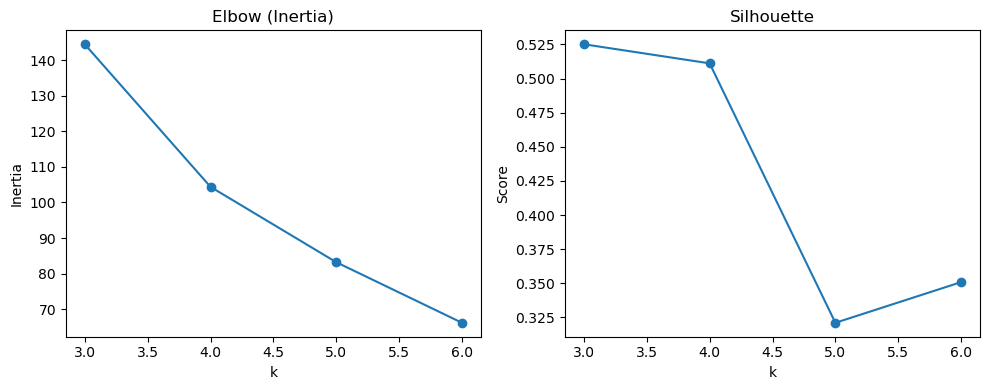

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_vars = ['slope_pm25','pm25_mean_over_window','pm25_latest','pm25_volatility','pm25_pct_change']
X = feat[cluster_vars].fillna(0.0).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = [3,4,5,6]
inertia, silhouettes = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(ks, inertia, marker='o'); plt.title('Elbow (Inertia)'); plt.xlabel('k'); plt.ylabel('Inertia')
plt.subplot(1,2,2); plt.plot(ks, silhouettes, marker='o'); plt.title('Silhouette'); plt.xlabel('k'); plt.ylabel('Score')
plt.tight_layout(); plt.show()

### Fit final K and derive human-readable labels

In [27]:
BEST_K = 3
km = KMeans(n_clusters=BEST_K, n_init=50, random_state=42)
feat['cluster'] = km.fit_predict(X_scaled)

median_latest = feat['pm25_latest'].median()

def label_cluster(slope, latest, slope_thr=0.0, latest_thr=median_latest):
    if slope < slope_thr and latest <= latest_thr: return 'Clean & Improving'
    if slope >= slope_thr and latest > latest_thr: return 'High & Worsening'
    if slope < slope_thr and latest > latest_thr: return 'High but Improving'
    return 'Moderate / Stagnant'

feat['cluster_label'] = feat.apply(lambda r: label_cluster(r['slope_pm25'], r['pm25_latest']), axis=1)
feat[['country','slope_pm25','pm25_latest','cluster_label']].head(10)

C:\Users\Mollean\anaconda3\envs\airquality\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,country,slope_pm25,pm25_latest,cluster_label
0,Albania,0.657325,23.161000,High & Worsening
1,United Arab Emirates,-1.156071,33.110000,High but Improving
2,Australia,0.278634,7.474557,Moderate / Stagnant
3,Austria,-0.627709,10.440171,Clean & Improving
4,Belgium,-0.748278,9.453909,Clean & Improving
5,Bangladesh,7.025939,86.481000,High & Worsening
6,Bulgaria,-0.158267,25.144714,High but Improving
7,Bahrain,-5.866800,43.390667,High but Improving
8,Bahamas,-1.015000,3.200000,Clean & Improving
9,Bosnia and Herzegovina,-3.628497,30.465667,High but Improving


### Map the clusters (country centroids from city coordinates)

In [25]:
import plotly.express as px

centroids = pm25.groupby(['iso3','country_name'], as_index=False).agg(lat=('latitude','mean'), lon=('longitude','mean'))
viz = feat.merge(centroids, left_on=['iso3','country'], right_on=['iso3','country_name'], how='left')

fig = px.scatter_geo(viz, lat='lat', lon='lon', color='cluster_label',
                     hover_name='country', size='pm25_latest',
                     projection='natural earth',
                     title='Country Clusters by PM2.5 Trajectory')
fig.show()

As per the evaluated K-Means for k ∈ {3,4,5,6}. 
The silhouette peaked at k=3 (~0.53) and decreased sharply for k=5; the elbow curve showed diminishing returns after k=4.
I selected k=3 for interpretability and separation.

Clusters were post-labeled using medians of trend slope and latest concentration:

Clean & Improving (low latest, negative slope),

High & Worsening (high latest, positive slope),

High but Improving / Moderate (mixed pattern). 

This segmentation supports quick identification of countries needing different policy responses.

### Export cluster results for Visualisation

In [40]:
feat_out = feat[['iso3','country','who_region',
                 'slope_pm25','pm25_mean_over_window','pm25_latest',
                 'pm25_volatility','pm25_pct_change',
                 'cluster','cluster_label']].sort_values(['cluster','country'])

feat_out_path = os.path.join(base_path, "out_country_clusters.csv")
feat_out.to_csv(feat_out_path, index=False)

#  Part B: Supervised Learning — Predicting NO₂

Using **Random Forest Regression** to predict NO₂ from PM2.5/PM10 + region + station type + year + population.

**Why RandomForest?** Handles non-linearity, interactions, and mixed feature types without heavy tuning.


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns

# Build city-year table then pivot pollutants wide
agg = (df.groupby(['iso3','country_name','city','who_region','type_of_stations','year','pollutant'], as_index=False)
         .agg(conc=('concentration','mean'), population=('population','mean')))

wide = agg.pivot_table(index=['iso3','country_name','city','who_region','type_of_stations','year','population'],
                       columns='pollutant', values='conc').reset_index()

mod = wide.dropna(subset=['no2']).copy()
for c in ['pm25','pm10','population']:
    mod[c] = mod[c].fillna(mod[c].median())

X = mod[['pm25','pm10','year','population','who_region','type_of_stations','country_name']]
y = mod['no2']

num_cols = ['pm25','pm10','year','population']
cat_cols = ['who_region','type_of_stations','country_name']

pre = ColumnTransformer([('num','passthrough',num_cols),
                         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)])

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
pipe = Pipeline([('pre', pre), ('rf', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("R²:", round(r2_score(y_test, pred), 3))
print("MAE:", round(mean_absolute_error(y_test, pred), 3))

R²: 0.769
MAE: 3.634


### Feature Importances

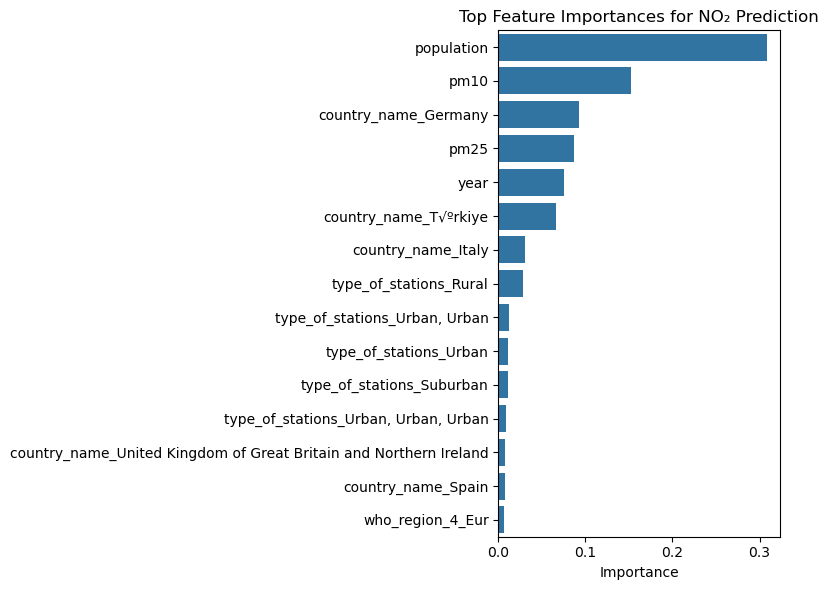

In [37]:
rf_model = pipe.named_steps['rf']
ohe = pipe.named_steps['pre'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, cat_names]

importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top Feature Importances for NO₂ Prediction")
plt.xlabel("Importance"); plt.ylabel("")
plt.tight_layout(); plt.show()

### Impute Missing NO₂ and Export

In [39]:
# Find rows where NO2 is missing but PM2.5/PM10 exist
to_impute = wide[wide["no2"].isna()].copy()
to_impute["pm25"] = to_impute["pm25"].fillna(mod["pm25"].median())
to_impute["pm10"] = to_impute["pm10"].fillna(mod["pm10"].median())
to_impute["population"] = to_impute["population"].fillna(mod["population"].median())

X_imp = to_impute[["pm25","pm10","year","population","who_region","type_of_stations","country_name"]]
to_impute["no2_pred"] = pipe.predict(X_imp)

# Export imputed results
to_impute_out = to_impute[["iso3","country_name","city","year","no2_pred"]]
to_impute_out.to_csv("out_no2_imputed.csv", index=False)